In [205]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [206]:
import torch
import torchvision.models as models
from torchvision import datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from PIL import ImageFile
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.metrics import confusion_matrix

In [207]:
train_data_dir = '/content/drive/My Drive/Colab Notebooks/Dataset/train'
valid_data_dir = '/content/drive/My Drive/Colab Notebooks/Dataset/validation'
test_data_dir = '/content/drive/My Drive/Colab Notebooks/Dataset/test'

In [208]:
# num_class = 2
# image_dim = 224
batch_size = 8

In [209]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

train_data_transform = transforms.Compose([transforms.Resize(244),
                                           transforms.CenterCrop(224),
                                           transforms.RandomRotation(10),                                          
                                           transforms.RandomHorizontalFlip(),
                                           transforms.ToTensor(),
                                           transforms.Normalize(mean=0.485,
                                                                std=0.229)])

valid_data_transform = transforms.Compose([transforms.Resize(244),
                                           transforms.CenterCrop(224),
                                           transforms.ToTensor(),
                                           transforms.Normalize(mean= 0.485 ,std= 0.229)])

test_data_transform = transforms.Compose([transforms.Resize(224),
                                           transforms.CenterCrop(224),
                                           transforms.ToTensor(),
                                           transforms.Normalize(mean= 0.485,
                                                                std= 0.229)])

train_data = datasets.ImageFolder(train_data_dir, transform=train_data_transform)
valid_data = datasets.ImageFolder(valid_data_dir, transform=valid_data_transform)
test_data = datasets.ImageFolder(test_data_dir, transform=test_data_transform)
train_data_load = DataLoader(train_data, batch_size = batch_size, shuffle = True)
valid_data_load = DataLoader(valid_data, batch_size = batch_size, shuffle = True)
test_data_load = DataLoader(test_data,batch_size=batch_size, shuffle = True)

In [210]:
use_cuda = torch.cuda.is_available()

In [211]:
len(valid_data_load)

25

In [212]:
loaders_transfer = {'train': train_data_load, 'valid': valid_data_load, 'test': test_data_load}

In [213]:
model_transfer = models.resnet18(pretrained=True)
model_transfer.out = nn.Bilinear(2048,2, 2)

if use_cuda:
    model_transfer = model_transfer.cuda() 

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [214]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.Adam(model_transfer.parameters(), lr=0.001)

In [215]:
tl,vl,ta=[],[],[]
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        train_loss = 0.0
        valid_loss = 0.0
        
        correct=0
        total=0

        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            optimizer.zero_grad()
            out = model(data)
            
            loss = criterion(out, target)
            
            loss.backward()
            optimizer.step()
            train_loss += ((1/(batch_idx + 1)) * (loss.data - train_loss))
            
            _, predicted = out.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()

        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            out = model(data)
            
            loss = criterion(out, target)
            valid_loss += ((1/(batch_idx + 1)) * (loss.data - valid_loss))
            
        ta.append(100. * correct/total) 
            
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.5f} \tValidation Loss: {:.5f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        tl.append(train_loss)
        vl.append(valid_loss)
        
        #save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Valid loss decrease to  ({:.5f} -> {:.5f}). Saving model ...'.format(valid_loss_min,valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
   
    # return trained model
    return model

In [216]:
n_epochs = 45
model_transfer = train(n_epochs, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

Epoch: 1 	Training Loss: 0.80812 	Validation Loss: 0.81195
Valid loss decrease to  (inf -> 0.81195). Saving model ...
Epoch: 2 	Training Loss: 0.31635 	Validation Loss: 1.01886
Epoch: 3 	Training Loss: 0.29724 	Validation Loss: 0.53929
Valid loss decrease to  (0.81195 -> 0.53929). Saving model ...
Epoch: 4 	Training Loss: 0.32001 	Validation Loss: 0.72430
Epoch: 5 	Training Loss: 0.30296 	Validation Loss: 0.64829
Epoch: 6 	Training Loss: 0.20294 	Validation Loss: 0.62415
Epoch: 7 	Training Loss: 0.23080 	Validation Loss: 0.67153
Epoch: 8 	Training Loss: 0.22093 	Validation Loss: 0.52882
Valid loss decrease to  (0.53929 -> 0.52882). Saving model ...
Epoch: 9 	Training Loss: 0.24768 	Validation Loss: 0.68763
Epoch: 10 	Training Loss: 0.22350 	Validation Loss: 0.78344
Epoch: 11 	Training Loss: 0.24872 	Validation Loss: 0.88242
Epoch: 12 	Training Loss: 0.17157 	Validation Loss: 0.71847
Epoch: 13 	Training Loss: 0.16919 	Validation Loss: 0.79084
Epoch: 14 	Training Loss: 0.14903 	Validatio

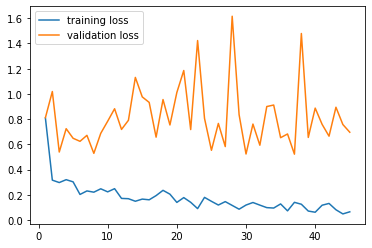

In [217]:
tl1=[]
vl1=[]
a=[]
for i in tl:
    tl1.append(float(i))
for i in vl:
    vl1.append(float(i))
for i in range(1,46):
    a.append(i)
plt.plot(a,tl1,label='training loss')
plt.plot(a,vl1,label='validation loss')
plt.legend()

97.5

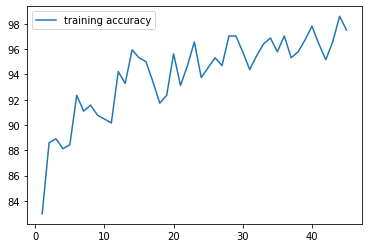

In [218]:
ta1=[]
for i in ta:
    ta1.append(float(i))
plt.plot(a,ta1,label='training accuracy')
plt.legend()
ta1[-1]

In [219]:
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

<All keys matched successfully>

In [220]:
testa,testl=[],[]
predicted,expected=[],[]
def test(loaders, model, criterion, use_cuda):

    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        output = model(data)
        loss = criterion(output, target) 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        pred = output.data.max(1, keepdim=True)[1]
        
        predicted.append(pred)
        expected.append(target.data)

        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
        print('Test Loss: {:.6f}\n'.format(test_loss))
        testl.append(float(test_loss))

        print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
            100. * correct / total, correct, total))
        testa.append(100. * correct / total)

In [221]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 1.037240


Test Accuracy: 62% ( 5/ 8)
Test Loss: 2.064576


Test Accuracy: 50% ( 8/16)
Test Loss: 1.437441


Test Accuracy: 62% (15/24)
Test Loss: 1.336812


Test Accuracy: 62% (20/32)
Test Loss: 1.229526


Test Accuracy: 62% (25/40)
Test Loss: 1.087380


Test Accuracy: 66% (32/48)
Test Loss: 1.116599


Test Accuracy: 64% (36/56)
Test Loss: 1.192331


Test Accuracy: 62% (40/64)
Test Loss: 1.067200


Test Accuracy: 66% (48/72)
Test Loss: 1.096129


Test Accuracy: 67% (54/80)
Test Loss: 1.016731


Test Accuracy: 69% (61/88)
Test Loss: 0.984014


Test Accuracy: 69% (67/96)
Test Loss: 0.925253


Test Accuracy: 71% (74/104)
Test Loss: 0.965735


Test Accuracy: 69% (78/112)
Test Loss: 1.022897


Test Accuracy: 68% (82/120)
Test Loss: 0.994849


Test Accuracy: 68% (88/128)
Test Loss: 1.008404


Test Accuracy: 68% (93/136)
Test Loss: 1.089388


Test Accuracy: 65% (94/144)
Test Loss: 1.078492


Test Accuracy: 65% (100/152)
Test Loss: 1.127485


Test Accuracy: 65% (104/160)
Test Loss:

In [222]:
ex=[]
for i in expected:
  for j in i:
    ex.append(int(j))
print(len(ex))

184


In [223]:
pr=[]
for i in predicted:
  for j in i:
    pr.append(int(j))
print(len(pr))

184


In [224]:
tp,tn,fp,fn=0,0,0,0
for i in range(len(ex)):
  if(ex[i]==1 and pr[i]==1):
    tp+=1
  elif(ex[i]==0 and pr[i]==0):
    tn+=1
  elif(ex[i]==0 and pr[i]==1):
    fp+=1
  elif(ex[i]==1 and pr[i]==0):
    fn+=1
print(tp,tn,fp,fn)

78 46 46 14


# New Section

In [225]:
precision=tp/(tp+fp)
print(precision)
recall=tp/(tp+fn)
print(recall)
f1_score=(2 * precision * recall) / (precision + recall)
print(f1_score)

0.6290322580645161
0.8478260869565217
0.7222222222222221


In [226]:
res=confusion_matrix(pr,ex)
print(res)

[[46 14]
 [46 78]]


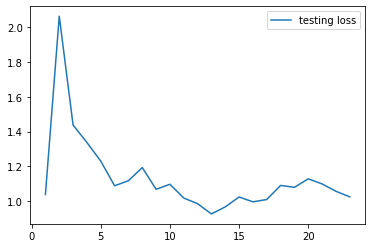

In [227]:
testl1=[]
a=[]
for i in testl:
    testl1.append(float(i))
for i in range(len(testl1)):
    a.append(i+1)
plt.plot(a,testl1,label='testing loss')
plt.legend()

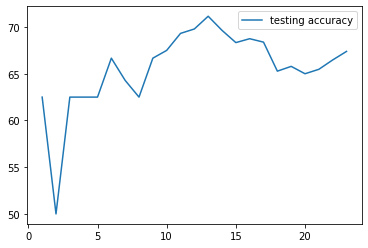

In [228]:
testa1=[]
for i in testa:
    testa1.append(float(i))
plt.plot(a,testa1,label='testing accuracy')
plt.legend()